In [ ]:
# According to this article https://arxiv.org/abs/1705.00105

In [3]:
import fastparquet
import time
import matplotlib.pyplot as plt
import os
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from collections import deque
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from tqdm import tqdm
pd.options.display.max_columns = 100
%matplotlib inline

### Выгружаем данные. Функция поочередной выгрузки данных и подготовки триплетов.

In [4]:
file_names = os.listdir("/data/vanya_dataset/train_val")
file_counter = 1

In [5]:
def get_next_triplets(train_batches_number=3, path="/data/vanya_dataset/train_val/", file_names=file_names):
    """
    Принимает количество батчей, которые нужно считать, путь к папке из которой читать и имена файлов для считывания.
    
    Возвращает 3 значения.
    1) triplets: (user_id, item_1, item_2, val(1, если item_1 лучше item_2, -1 иначе))
    2) raw_data -- сухие данные смерженных батчей.
    3) raw_pay_train -- сухие данные колонок ['event_id'] + колонки соответствующие категориям. 
    """

    raw_data = pd.DataFrame()
    for ind, name in enumerate(file_names[file_counter:]):
        if ind == train_batches_number:
            break
        pfile = fastparquet.ParquetFile(path + name)
        batch = pfile.to_pandas()
        print("+")
        if ind == 0:
            raw_data = batch
            continue
        else:
            raw_data = pd.concat([raw_data, batch])
    global file_counter
    file_counter += train_batches_number
    print("Всего примеров: ", raw_data.shape[0])
    print("Всего уникальных юзеров: ", raw_data.user_id.unique().shape[0])
    # Распределение данных по классам.
    plt.scatter(range(58), raw_data[raw_data.columns[-58:]].mean().values)
    
    raw_pay_train = raw_data[['event_id'] + raw_data.columns[-58:].tolist()]
    # Выбираем ненулевые индексы в категориях(по ним платили), для того чтобы потом построить по ним триплеты.
    non_zero_indexes = np.argwhere((raw_pay_train.iloc[:, :].loc[:, [str(float(i)) 
                                                                     for i in list(range(0,57))] ] > 0).values)
    indx_df = pd.DataFrame(non_zero_indexes)
    # Мержим все категории друг к другу для каждого юзера.
    triplets = pd.merge(indx_df, indx_df, on=indx_df.columns[0])
    triplets = triplets[triplets['1_x'] != triplets['1_y']]
    train_data = raw_pay_train.values    
    trip_data = triplets.values
    l = triplets.shape[0]
    # Хотим 1, если item_1 лучше item_2, -1 иначе.
    val = np.zeros(l)
    for i in range(l):
        # Получаем номер юзера.
        row = trip_data[i][0]
        # Сдвигаемся на 1 вперед, так как первая колонка это номер юзера, а мы хотим номер категории.
        x = trip_data[i][1] + 1
        y = trip_data[i][2] + 1
        if train_data[row][x] >= train_data[row][y]:
            val[i] = 1.
        else:
            val[i] = -1.
    # Добавляем.
    triplets = triplets.assign(val=val)
    tripl_data = triplets.values
    indexes = np.zeros(l)
    for i in range(l):
        # Старый id ивента/юзера в триплете.
        row = int(tripl_data[i][0])
        # На i-й позиции стоит старый индекс i-й строки.
        indexes[i] = int(train_data[row][0])
    triplets[triplets.columns[0]] = indexes.astype(int)
    triplets = triplets.rename(columns={triplets.columns[0]: 'user_id'})
    
    return triplets, raw_data, raw_pay_train

+
+
+
+
+
Всего примеров:  1070279
Всего уникальных юзеров:  847958
CPU times: user 1min 22s, sys: 3.43 s, total: 1min 25s
Wall time: 1min 25s


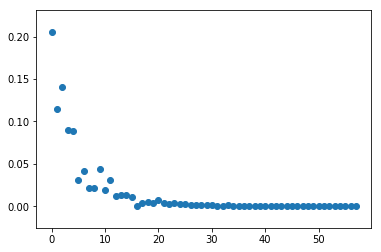

In [7]:
%%time
triplets, raw_data, raw_pay_train = get_next_triplets(train_batches_number=5)

In [8]:
# Так как пользователей много сделаем отображение из номеров в range (1, кол-во пользователей).
users = raw_pay_train.event_id.unique()
users_map = {}
for index, user in enumerate(users):
    users_map[user] = index
    
def get_users_map(lst):
    res = []
    for u in lst:
        res.append(users_map[u])
    return np.array(res)

In [9]:
triplets.shape

(22397896, 4)

### Описание структура нейронной сети и функций потерь. Сам подсчет ошибки идет в функции Train_net

In [10]:
# Необходимо для проведения вычислений на видеокарте, если она имеется.
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
print("Cuda: ", use_cuda)

Cuda:  True


In [11]:
def get_random_sample(triplets, N=84):
    """
    Получаем случайное подмножество из triplets размера N.
    """
    #indexes = np.random.randint(len(triplets), size=N)
    indexes = random.sample(range(0, len(triplets)), N)
    return triplets.iloc[indexes]

def torch_mean_logloss(raw_margins, target_values, trunc_max=100.):
    """
    Считаем logloss. raw_margins и target_values вектора.
    """
    # -y * f(x), минус уже учтен при подсчете margins
    
    myfx = -1. * torch.mul(target_values.float(), raw_margins)
    elementwise_logloss = torch.log(1 + torch.exp(myfx))
    mean_loss = torch.clamp(elementwise_logloss, max=trunc_max).mean()
    return mean_loss

def torch_mean_l2(w):
    """
    L2 регуляризация для вектора w.
    """
    elementwise_sq_norm = w.pow(2).sum(dim=1)
    mean_l2 = elementwise_sq_norm.mean()
    return mean_l2

In [12]:
class InterNet(nn.Module):
    """
    Класс нейронной сети.
    Мы используем эту сеть, как структурную единицу сети, которую используем непосредственно.
    На вход подается два среза итемов для какого-то юзера. 
    На выходе число, если > 0 то сеть считает левый итем лучше правого, < 0 иначе.
    """
    
    def __init__(self, N_EMBEDDINGS):
        super(InterNet, self).__init__()
        # Задаем слои
        self.fc1 = nn.Linear(N_EMBEDDINGS * 2, 100)
        self.fc2 = nn.Linear(100, 100)
        #self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 1)
        
        #self.model = torch.nn.Sequential(
        #torch.nn.Linear(N_EMBEDDINGS * 2, 200),
        #torch.nn.ReLU(),
        #torch.nn.Linear(400, 200),
        #torch.nn.ReLU(),
        #torch.nn.Linear(200, 84),
        #torch.nn.Tanh(),
        #torch.nn.Linear(84, 1)
        #)
    
    
    def forward(self, x):
        # Set activation function.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        #x = self.model(x)|
        return x

class Net(nn.Module):
    """
    Класс нейронной сети.
    Contains InterNet class, and embeddings for it.
    """
    def __init__(self, n_user, n_items, n_embeddings=40, alpha=0.9, beta=0.4, alpha_reg=0.0001):
        """
        n_user, n_items,
        n_embeddings = размер вложенного слоя(длина представления каждого юзера или итема
        как вектора).
        alpha = коэффициент учета embedding ошибки, то есть ошибки вычисляемой по векторам срезам.
        beta = коэффициент учета net ошибки, то етсь ошибки вычисляемой по выходу нейронной сети.
        alpha_reg = коэффициент регуляризации.
        """
        super(Net, self).__init__()
        self.N_USERS = n_user
        self.N_ITEMS = n_items
        self.N_EMBEDDINGS = n_embeddings
        self.alpha = alpha
        self.beta = beta
        self.alpha_reg = alpha_reg
        self.alpha_diff = 0
        
        # Initialize embeddings randomly.
        initrange = 1.0
        self.user_latents = nn.Embedding(self.N_USERS,self.N_EMBEDDINGS)
        self.item_latents = nn.Embedding(self.N_ITEMS,self.N_EMBEDDINGS)
        self.user_latents.weight.data.uniform_(0, initrange)
        self.item_latents.weight.data.uniform_(0, initrange)
        
        self.user_latents = self.user_latents.cuda()
        self.item_latents = self.item_latents.cuda()
        
        self.net_l = InterNet(self.N_EMBEDDINGS)
        #self.net_r = InterNet(self.N_EMBEDDINGS)
        
    
    def forward(self, xl, xr, p = False):       
        #r = self.net_r.forward(xr)
        r = self.net_l.forward(xr)
        l = self.net_l.forward(xl) 
        if p :
            print(l.data.numpy(),"/////",r.data.numpy())
        y = l - r
        return y

In [13]:
net = Net(raw_pay_train.event_id.unique().shape[0], 57, n_embeddings=40, alpha=0.9, beta=0.4, alpha_reg=0.0001)

# необходимое действие для работы с GPU.
if use_cuda:
    net.cuda()
# массивы для вычисления ошибок на каждом шаге.
dots = []
dots_2 = []
optimizer=optim.Adam(net.parameters(), lr=0.0001)
print(net)

Net (
  (user_latents): Embedding(1070279, 40)
  (item_latents): Embedding(57, 40)
  (net_l): InterNet (
    (fc1): Linear (80 -> 100)
    (fc2): Linear (100 -> 100)
    (fc4): Linear (100 -> 1)
  )
)


In [14]:
def get_prediction(user_id, left, right, net=net):
    """
    Предсказание нейронной сети net для юзера с user_id, и двух предметов left и right.
    Если результат >= 0, то left >=right, left < right иначе.
    """
    # Необходимо для правильной работы метода get_range_user.
    if left == -1:
        return Variable(FloatTensor([-1]))
    if right == -1:
        return Variable(FloatTensor([1]))
     
    user_ids = Variable(torch.from_numpy(get_users_map(np.array([user_id]).astype(int))).cuda())
    left_ids = Variable(torch.from_numpy(np.array([left]).astype(int)).cuda())
    right_ids = Variable(torch.from_numpy(np.array([right]).astype(int)).cuda())
    
    embedding_user = net.user_latents(user_ids)
    embedding_left = net.item_latents(left_ids)
    embedding_right = net.item_latents(right_ids) 
    
    xr = torch.cat((embedding_user,embedding_right), 1)
    xl = torch.cat((embedding_user,embedding_left), 1)
    
    # get predictions
    net_margins = net.forward(xl,xr)
    return net_margins

In [15]:
items=list(range(49))

def get_range_user(user_id=1, top=10, items=items, net=net):
    """
    Для юзера с user_id получаем лучшие top категорий из items.
    
    Мы предполагаем, что существует линейный порядок среди items, на самом же деле это нигде не гарантируется,
    поэтому возможны циклы, но мы не берем это во внимание.
    """
    res = deque([-1] * top)
    i_s = 0
    s = 2
    if top > 1:
        if get_prediction(user_id, items[0], items[1], net=net) > get_prediction(user_id, items[1], items[0], net=net):
            res[0] = items[0]
            res[1] = items[1]
            i_s = items[0]
        else:
            res[0] = items[1]
            res[1] = items[0]
            i_s = items[1]
    else:
        s = 1
        res[0] = items[0]
    k = top - 1
    for i in items[s:]:
        i_s = res[0]
        j = top - 1
        while((j >= 0) and (get_prediction(user_id, i, res[j], net=net).cpu().data.numpy() >= 0.)):
            j -= 1
        if j < k:
            #right(res, j)
            res.insert(j+1, i)
            res.pop()
    return res

In [16]:
# Prepare data for pr_connection_test.
needed_categories = ['util_30', 'internet_pay_30', 'transfer_pay_30', 'loan_pay_30', 'loan_w_Card_pay_30', 'event_id']

conn_test = raw_data[needed_categories]

clean_test = conn_test.drop(conn_test[(conn_test.util_30==0) & (conn_test.internet_pay_30==0) & (conn_test.transfer_pay_30==0)\
          & (conn_test.loan_pay_30==0) & (conn_test.loan_w_Card_pay_30==0)].index)

clean_values = clean_test.values
print("users in test: ", clean_values.shape)

users in test:  (996, 6)


In [17]:
def locker(util, internet, transfer, loan, raw):
    """
    Count False Negative and true negative for all classes.
    """
    if raw[0] == 1:
        util[1][0] += 1
        internet[1][1] += 1
        transfer[1][1] += 1
        loan[1][1] += 1
    elif raw[3] == 1 or raw[4] == 1:
        util[1][1] += 1
        internet[1][1] += 1
        transfer[1][1] += 1
        loan[1][0] += 1
    elif raw[1] == 1:
        util[1][1] += 1
        internet[1][0] += 1
        transfer[1][1] += 1
        loan[1][1] += 1
    elif raw[2] == 1:
        util[1][1] += 1
        internet[1][1] += 1
        transfer[1][0] += 1
        loan[1][1] += 1
    return

def pr_connection_test(target_number=5, test_number=clean_values.shape[0], clean_values=clean_values, net=net):
    """
    Test.
    Test number=number of rows to test.
    clean_values = test_data.
    net = Newral network.
    """
    
    items = [49, 42, 15, 48]
    true = 0
    false = 0
    # Matrices with such columns.
    # True positive False Positive
    # False negative True negative
    util = np.zeros((2, 2))
    internet = np.zeros((2, 2))
    transfer = np.zeros((2, 2))
    loan = np.zeros((2, 2))
    raw_val = raw_data.values
    l_util = 0
    l_internet = 0
    l_transfer = 0
    l_loan = 0
    
    counter = 0
    for raw in clean_values[:test_number]:
        user = raw[5]
        our_prediction_top = get_range_user(user, top=4, items=items, net=net)
        our_prediction = [our_prediction_top[0]]
        if 42 in our_prediction:
            if raw[0] == 1:
                if raw_val[users_map[user]][13 + 42] == 0:
                    l_util += 1
                true +=1
                util[0][0] += 1
                internet[1][1] += 1
                transfer[1][1] += 1
                loan[1][1] += 1
            else:
                false += 1
                util[0][1] += 1
                locker(util, internet, transfer, loan, raw)
                # Мы добавили лишнюю единицу в util.
                util[1][1] -= 1
                
        elif 49 in our_prediction:
            if raw[3] == 1 or raw[4] == 1:
                true += 1
                if raw_val[users_map[user]][13 + 49] == 0:
                    l_loan += 1
                util[1][1] += 1
                internet[1][1] += 1
                transfer[1][1] += 1
                loan[0][0] += 1
            else:
                false += 1
                
                loan[0][1] += 1
                locker(util, internet, transfer, loan, raw)
                # Мы добавили лишнюю единицу в util.
                loan[1][1] -= 1
        elif 15 in our_prediction:
            if raw[1] == 1:
                true += 1
                if raw_val[users_map[user]][13 + 15] == 0:
                    l_internet += 1
                util[1][1] += 1
                internet[0][0] += 1
                transfer[1][1] += 1
                loan[1][1] += 1
            else:
                false += 1
                internet[0][1] += 1
                locker(util, internet, transfer, loan, raw)
                # Мы добавили лишнюю единицу в util.
                internet[1][1] -= 1
                
        elif 48 in our_prediction:
            if raw[2] == 1:
                true += 1
                if raw_val[users_map[user]][13 + 48] == 0:
                    l_transfer += 1
                util[1][1] += 1
                internet[1][1] += 1
                transfer[0][0] += 1
                loan[1][1] += 1
            else:
                false += 1
                transfer[0][1] += 1
                locker(util, internet, transfer, loan, raw)
                # Мы добавили лишнюю единицу в util.
                transfer[1][1] -= 1
        counter += 1
        #if counter % 500 == 0:
            #print("Pred: ", our_prediction)
            #print(raw[1: 5])
    print("ЖКУ: ", util, "ROC: ", util[0][0]/(util[1][0] + util[0][0]) / (1 - util[1][1] / (util[1][1] + util[0][1]))
        , "Precision: ", util[0][0] / (util[0][0] + util[0][1]),"ls: ", l_util)
    print("Интернет: ", internet, "ROC: ", internet[0][0]/(internet[1][0] + internet[0][0]) 
          / (1 - internet[1][1] / (internet[1][1] + internet[0][1])),
         "Precision: ", internet[0][0] / (internet[0][0] + internet[0][1]),"ls: ", l_internet )
    print("Переводы: ", transfer, "ROC: ", transfer[0][0]/(transfer[1][0] + transfer[0][0]) 
          / (1 - transfer[1][1] / (transfer[1][1] + transfer[0][1])),
         "Precision: ", transfer[0][0] / (transfer[0][0] + transfer[0][1]),"ls: ", l_transfer )
    print("Кредиты: ", loan, "ROC: ", loan[0][0]/(loan[1][0] + loan[0][0]) 
          / (1 - loan[1][1] / (loan[1][1] + loan[0][1])),
         "Precision: ", loan[0][0] / (loan[0][0] + loan[0][1]) ,"ls: ", l_loan)
            
    return true, false, util, internet, transfer, loan

In [18]:
net = Net(raw_pay_train.event_id.unique().shape[0], 57, n_embeddings=40, 
          alpha=0.9, beta=0.4, alpha_reg=0.001)

if use_cuda:
    net.cuda()

dots = []
dots_2 = []
accuracy = []
optimizer=optim.Adam(net.parameters(), lr=0.0001)
print(net)

Net (
  (user_latents): Embedding(1070279, 40)
  (item_latents): Embedding(57, 40)
  (net_l): InterNet (
    (fc1): Linear (80 -> 100)
    (fc2): Linear (100 -> 100)
    (fc4): Linear (100 -> 1)
  )
)


In [19]:
def Train_net(batch_size=1024, triplets=triplets, n_epoch=10000,
              optimizer=optimizer, net=net):
    
    """
    Запускает тренировку сети net на триплетах triplets.
    
    Ошибка считается согласно статье.
    """
    
    net_running_loss = 0.0
    running_loss = 0.0
    ind = 0

    for epoch in range(n_epoch):
        # get random batch 
        numpy_x_sample = get_random_sample(triplets, batch_size)
        
        user_ids = Variable(torch.from_numpy(
            get_users_map(numpy_x_sample.loc[:,"user_id"].values.astype(int))).cuda())
        left_ids = Variable(torch.from_numpy(numpy_x_sample.loc[:,"1_x"].values.astype(int)).cuda())
        right_ids = Variable(torch.from_numpy(numpy_x_sample.loc[:,"1_y"].values.astype(int)).cuda())
        target_y = Variable(torch.from_numpy(numpy_x_sample.loc[:,"val"].values.astype(int)).cuda(), requires_grad=False)
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # Get sections from embedding matrices.
        embedding_user = net.user_latents(user_ids)
        embedding_left = net.item_latents(left_ids)
        embedding_right = net.item_latents(right_ids) 
        
        # Считаем ошибку.
        left_emb = torch.sum(embedding_user * embedding_left, 1)
        right_emb = torch.sum(embedding_user * embedding_right, 1)
        embedding_margins = left_emb - right_emb
        embedding_loss = torch_mean_logloss(embedding_margins, target_y)
    
        xr = torch.cat((embedding_user,embedding_right), 1)
        xl = torch.cat((embedding_user,embedding_left), 1)
    
        net_margins = net.forward(xl,xr)
        net_loss = torch_mean_logloss(net_margins, target_y)
        net_running_loss += net_margins.data[0]
        regularization = torch_mean_l2(embedding_user) + torch_mean_l2(embedding_left) + \
        torch_mean_l2(embedding_right)
        ranking_losses = net.alpha * embedding_loss + net.beta * net_loss
        target = ranking_losses + net.alpha_reg * regularization
    
        # backward pass
        target.backward()
        optimizer.step()
    
        # print statistics
        running_loss += target.data[0]
        #dots.append(target.data[0])
        #dots_2.append(running_loss / (epoch + 1))
        ind+=1
        if ind % 5000 == 0:
            print('[%d] loss: %.3f' %
                  (epoch + 1, running_loss / (epoch + 1)))
            true, false, util, internet, transfer, loan = pr_connection_test(test_number=clean_values.shape[0],
                                                                             clean_values=clean_values, net=net)
            acc = true / (true + false)
            accuracy.append(acc)
            print("accuracy: ", acc)
            
            #my_NDCG(target_number=5)

In [ ]:
%%time
Train_net(net=net)

In [53]:
def get_ktest(top, net=net):
    """
    Test.
    Returns how many items in top we will find from interesting classes.
    """
    
    items=list(range(12,30)) + [48]
    raw_values = raw_data.values
    
    internet_true = 0
    internet_false = 0
    transfer_true = 0
    transfer_false = 0
    for i in tqdm(range(raw_data.shape[0])[:1000]):
        user = raw_values[i][0]
        our_prediction = get_range_user(user, top=top, items=items, net=net)
        if 15 in our_prediction:
            if  raw_values[i][3] == 1:
                internet_true += 1
            else:
                internet_false += 1
        if 48 in our_prediction:
            if  raw_values[i][4] == 1:
                transfer_true += 1
            else:
                transfer_false += 1
        
    return internet_true, internet_false, transfer_true, transfer_false

In [20]:
net = Net(raw_pay_train.event_id.unique().shape[0], 57, n_embeddings=60, 
          alpha=0.9, beta=0.4, alpha_reg=0.001)
optimizer=optim.Adam(net.parameters(), lr=0.0001)
print(net)

def start_batch_eating(iterations=5, net=net):
    """
    Function that automatically takes 3 batches per iteration,
    learn net on them and print test metrics.
    """
    
    for i in range(iterations):
        global raw_data
        global triplets
        global raw_pay_train
        triplets, raw_data, raw_pay_train = get_next_triplets(train_batches_number=3)
        # Так как пользователей много сделаем отображение из номеров в range (1, кол-во пользователей).
        users = raw_pay_train.event_id.unique()
        global users_map
        
        users_map = {}
        print("raw_pay_train len: ", raw_pay_train.shape[0])
        for index, user in enumerate(users):
            users_map[user] = index
        print("upd1: ", len(users_map), list(users_map)[:3])
        needed_categories = ['util_30', 'internet_pay_30', 'transfer_pay_30', 'loan_pay_30', 'loan_w_Card_pay_30', 'event_id']
    
        conn_test = raw_data[needed_categories]
        print("conn test: ", conn_test.shape[0])
        clean_test = conn_test.drop(conn_test[(conn_test.util_30==0) & (conn_test.internet_pay_30==0) & (conn_test.transfer_pay_30==0)\
                  & (conn_test.loan_pay_30==0) & (conn_test.loan_w_Card_pay_30==0)].index)
        global clean_values
        clean_values = clean_test.values
        print("users in test: ", clean_values.shape)
        
    
        if use_cuda:
            net.cuda()
        
        dots = []
        dots_2 = []
        accuracy = []
        
        Train_net(triplets=triplets, optimizer=optimizer, net=net)
        
        #true, false, util, internet, transfer, loan = pr_connection_test(target_number=5, 
        #                        test_number=clean_values.shape[0], clean_values=clean_values, net=net)
        #print("Accuracy: ", true/(true + false))

Net (
  (user_latents): Embedding(1070279, 60)
  (item_latents): Embedding(57, 60)
  (net_l): InterNet (
    (fc1): Linear (120 -> 100)
    (fc2): Linear (100 -> 100)
    (fc4): Linear (100 -> 1)
  )
)


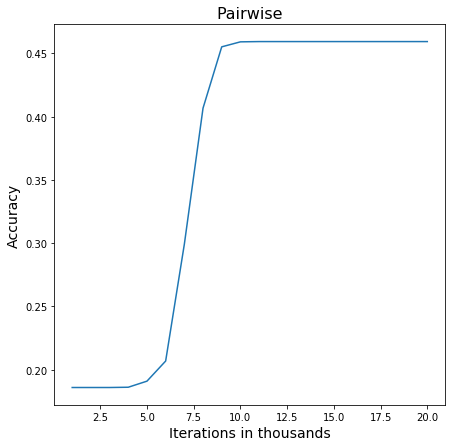

In [34]:
fig = plt.figure(figsize=(7,7))
plt.plot(range(1, len(accuracy) + 1), accuracy)
plt.xlabel("Iterations in thousands", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title('Pairwise', fontsize=16)
plt.show()